# Fourier sine series

For a function $f(x)$ defined on $x \in [0,1]$, the [Fourier sine series](http://en.wikipedia.org/wiki/Fourier_sine_and_cosine_series) writes $f(x)$ as:

* $f(x) = \sum_{n=1}^\infty b_n \sin(n\pi x)$

where the coefficients $b_n$ can be found by integration:

* $b_m = 2 \int_0^1 f(x) \sin(m\pi x) dx$.

Let's define a function `sinecoef` in [Julia](http://julialang.org) to compute these [integrals numerically](http://en.wikipedia.org/wiki/Numerical_integration), using Julia's [quadgk](http://docs.julialang.org/en/latest/stdlib/base/?highlight=quadgk#Base.quadgk) function  We'll use the `abstol` parameter to set an integration tolerance: we want the error to be small compared to $\sqrt{\int_0^1 |f(x)|^2 dx}$.

In [1]:
sinecoef(f, m) = 2 * quadgk(x -> f(x) * sin(m*π*x), 0,1, abstol=1e-8 * sqrt(quadgk(x->abs2(f(x)),0,1)[1]))[1]

# and another function to work on a vector of integers
sinecoef(f, M::AbstractVector) = Float64[sinecoef(f,m) for m in M]

sinecoef (generic function with 2 methods)

## A sine-series example

For example, if we have the function $f(x) = 0.5 - |x - 0.5|$, the first 20 coefficients are:

In [2]:
f(x) = 0.5 - abs(x - 0.5)
sinecoef(f, 1:20)

20-element Array{Float64,1}:
  0.405285   
  5.03187e-18
 -0.0450316  
  1.82116e-17
  0.0162114  
 -2.0849e-17 
 -0.00827112 
 -1.25544e-17
  0.00500352 
  4.70332e-17
 -0.00334946 
 -7.30892e-18
  0.00239813 
 -2.34147e-16
 -0.00180127 
 -8.72534e-17
  0.00140237 
  3.67697e-16
 -0.00112267 
 -4.11412e-16

(Notice that $b_n = 0$ for *even* $n$, which correspond to *antisymmetric* sine functions that integrate to zero against this *symmetric* $f$.)   The coefficients seem to be converging (getting smaller), as we would hope for a convergent series.  Let's plot them.

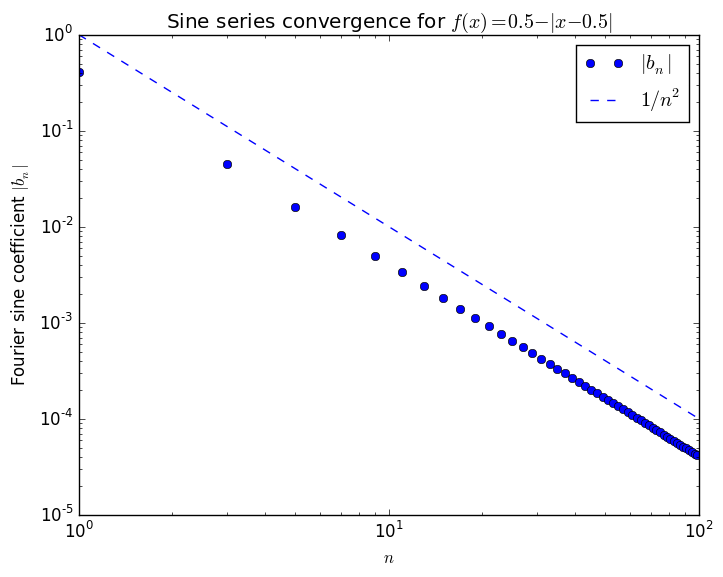

PyObject <matplotlib.legend.Legend object at 0x31f81b310>

In [3]:
using PyPlot
n = 1:2:99 # odd integers from 1 to 99
loglog(n, abs(sinecoef(f, n)), "bo")
xlabel(L"n")
ylabel(L"Fourier sine coefficient $|b_n|$")
title(L"Sine series convergence for $f(x) = 0.5 - |x - 0.5|$")
loglog(n, 1 ./ n.^2, "b--")
legend([L"|b_n|", L"1/n^2"])

They decay asymptotically as $1/n^2$.  It turns out that one can prove this from the fact that $f(x)$ is continuous with a discontinuous slope.

Now let's plot the series itself and compare it to $f(x)$.  We'll use Julia's [Interact package](https://github.com/JuliaLang/Interact.jl) so that we can drag a slider to control the number of terms in the series.

In [4]:
# First, define a function to evaluate N terms of the sine series, given the coefficients b
function sinesum(b, x)
    f = 0.0
    for n = 1:length(b)
        f += b[n] * sin(n*π*x)
    end
    return f
end
sinesum(b, X::AbstractVector) = Float64[sinesum(b,x) for x in X]

sinesum (generic function with 2 methods)

Interact.Slider{Int64}([Reactive.Input{Int64}] 49,"n",49,1:2:99)

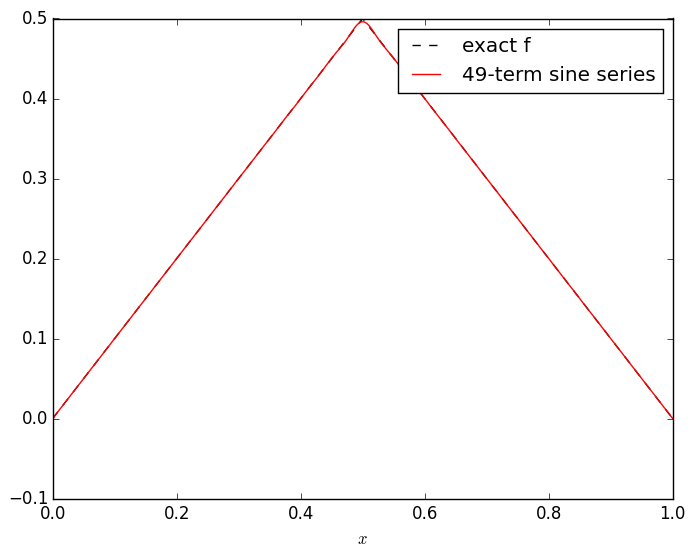

In [5]:
using Interact
fig = figure()
x = linspace(0,1, 1000)
@manipulate for n=1:2:99
    withfig(fig) do
        plot(x, f(x), "k--")
        b = sinecoef(f, 1:n)
        plot(x, sinesum(b, x), "r-")
        xlabel(L"$x$")
        legend(["exact f", "$n-term sine series"])
    end
end

In contrast, if we make a smoother function, e.g. $g(x) = \sin(\sin(3 \pi x) + 5\sin(\pi x))$, then it eventually converges *much* more quickly (in fact, for a smooth function like this the series converges *exponentially* fast):

Interact.Slider{Int64}([Reactive.Input{Int64}] 19,"n",19,1:2:37)

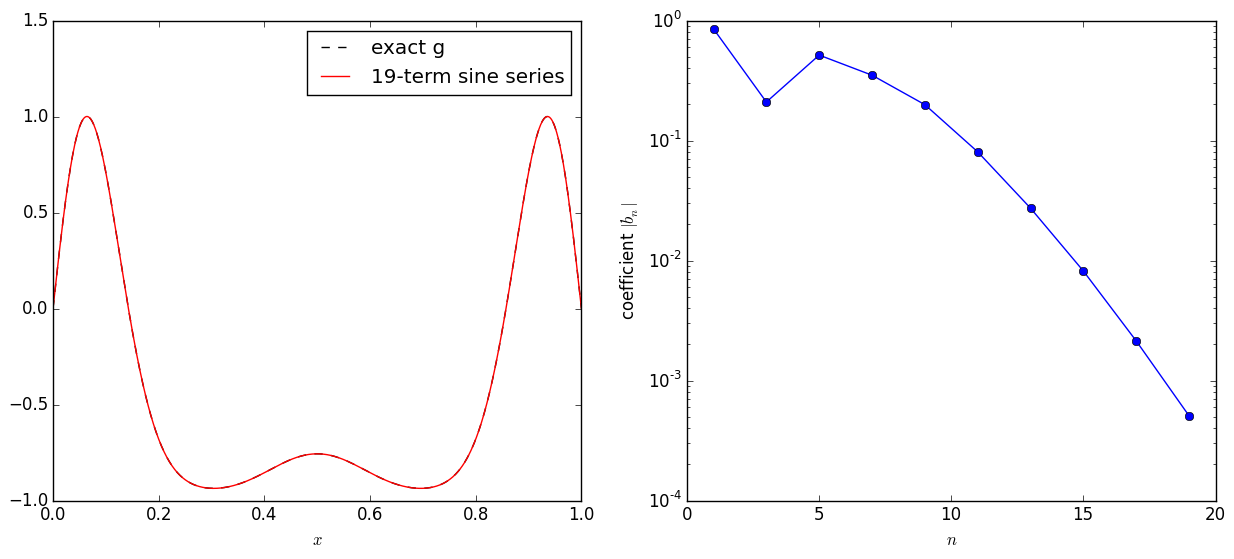

In [6]:
using Interact
fig = figure(figsize=(15,6))
g(x) = sin(sin(3π*x) + 5*sin(π*x))
@manipulate for n=1:2:37
    withfig(fig) do
        subplot(1,2,1)
        plot(x, g(x), "k--")
        b = sinecoef(g, 1:n)
        plot(x, sinesum(b, x), "r-")
        xlabel(L"x")
        legend(["exact g", "$n-term sine series"])
        
        subplot(1,2,2)
        semilogy(1:2:n, abs(b[1:2:n]), "bo-")
        xlabel(L"n")
        ylabel(L"coefficient $|b_n|$")
    end
end

## Solving the heat/diffusion equation

If we have the heat equation $\frac{\partial^2 u}{\partial x^2} = \frac{\partial u}{\partial t}$, with Dirichlet boundary conditions $u(0,t) = u(1,t) = 0$, and initial condition $u(x,0) = f(x)$, we can solve the equation by expanding $u(x,t)$ in a Fourier sine series.  From class:

* $u(x,t) = \sum_{n=0}^\infty b_n \sin(n\pi x) e^{-(n\pi)^2 t}$

where $b_n$ are the sine-series coefficients of the initial condition $f(x)$.

Let's plot this for different times $t$ for the $f(x) = 0.5 - |x - 0.5|$ from above, using 199 terms in the series:

Interact.Slider{Float64}([Reactive.Input{Float64}] 0.0,"time t",0.0,0.0:0.001:1.0)

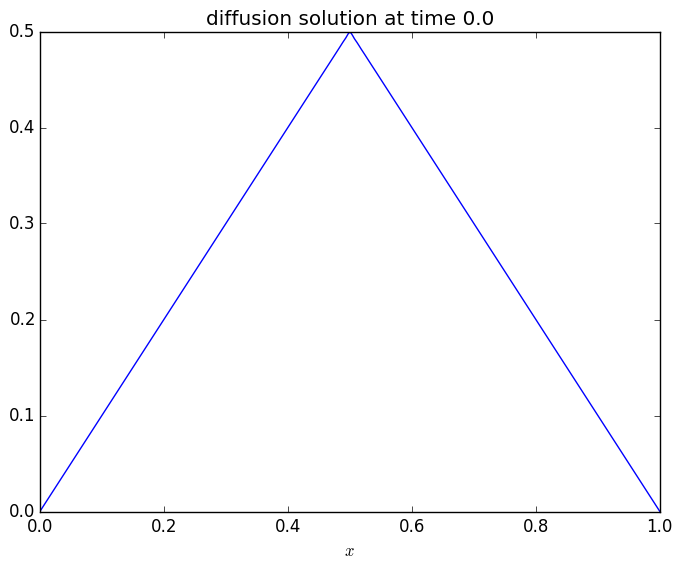

In [7]:
fig = figure()
@manipulate for t in slider(0:0.001:1, value=0.0, label="time t")
    withfig(fig) do
        plot(x, sinesum(sinecoef(f, 1:199) .* exp(-((1:199)*π).^2 * t), x))
        xlabel(L"x")
        title("diffusion solution at time $t")
        ylim(0,0.5)
    end
end

Notice that the sharp kink (the slope discontinuity) "diffuses away" almost immediately, because that sharp kink is created by the high-frequency sine-series terms that decay very rapidly.  After a short while, in fact, the solution just looks like $\sin(\pi x)$, because it is dominated by the $n=1$ term in the series.

## Solving the wave equation

If we have the *wave* equation $\frac{\partial^2 u}{\partial x^2} = \frac{\partial^2 u}{\partial t^2}$, with Dirichlet boundary conditions $u(0,t) = u(1,t) = 0$, and initial conditions $u(x,0) = f(x)$ and $\dot{u}(x,0) = 0$, we can also solve the equation by expanding $u(x,t)$ in a Fourier sine series.  From class:

* $u(x,t) = \sum_{n=0}^\infty b_n \sin(n\pi x) \cos{n\pi t}$

where $b_n$ are the sine-series coefficients of the initial condition $f(x)$.

Let's again plot this for different times $t$ for the $f(x) = 0.5 - |x - 0.5|$ from above, using 199 terms in the series:

Interact.Slider{Float64}([Reactive.Input{Float64}] 0.0,"time t",0.0,0.0:0.01:10.0)

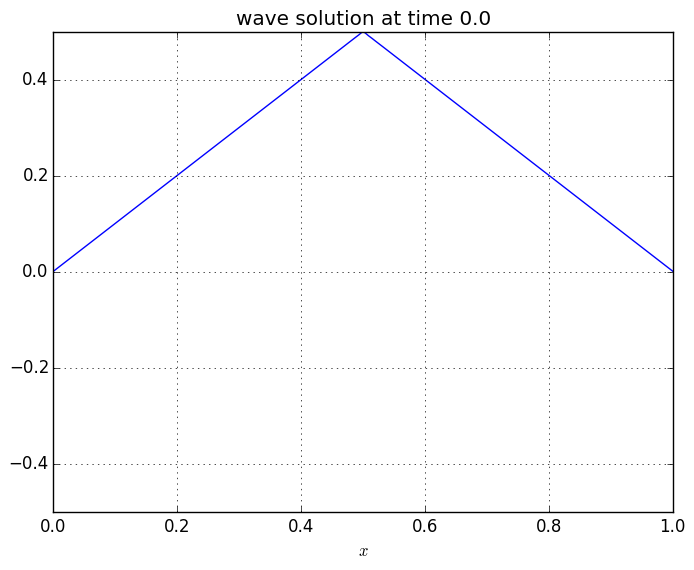

In [8]:
fig = figure()
@manipulate for t in slider(0:0.01:10, value=0.0, label="time t")
    withfig(fig) do
        plot(x, sinesum(sinecoef(f, 1:199) .* cos(((1:199)*π) * t), x))
        xlabel(L"x")
        title("wave solution at time $t")
        ylim(-0.5,0.5)
        grid()
    end
end

Now we have an oscillating wave, which bounced up and down between two triangle shapes.

(This may seem unrealistic to you: if you actually stretch a string into a triangle shape and let it go, it doesn't retain the sharp kinks seen here.  That is due to an effect called *dispersion* that we are not including in the wave equation...yet.)